In [23]:
from GT import get_dataset, denormalize
import matplotlib.pyplot as plt
from GT import GTM
from GT import gmm_loss
import json
import torch
from MMD import mmd_poly, mmd_linear, mmd_rbf
import numpy as np
import os
from tsl.datasets import AirQuality, MetrLA, PemsBay

DATASET_NAME = 'AirQuality'
MODEL_NAME= 'GMM'

# Magic
MODELS_PATH = f'./models'
IMAGES_PATH = f'./PNG'
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu' if torch.backends.mps.is_available() else 'cpu'
torch.set_default_device(DEVICE)

In [24]:
if not os.path.exists(f'{MODELS_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{MODELS_PATH}/{DATASET_NAME}')
if not os.path.exists(f'{IMAGES_PATH}/{DATASET_NAME}/'):
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/History')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Train')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Validation')
    os.makedirs(f'{IMAGES_PATH}/{DATASET_NAME}/Test')

## Model parameters

In [25]:
# Model Parameters 100 hidden
hidden_size = 128
num_layers = 1
lr = 0.001
weight_decay = 0.001
# weight_decay = 0
dropout = 0
bidirectional = True
mixture_dim = 32
debug = False
train_from_checkpoint = False
dataset = AirQuality(impute_nans=True, small=True)


## Dataset

In [26]:
dataset = dataset.dataframe()[-1000:]

In [27]:
dataset

nodes,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,...,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036
channels,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
datetime,,,,,,,,,,,,,,,,,,,,,
2015-03-20 08:00:00,41.0,22.0,20.0,28.0,39.0,34.0,24.0,29.0,25.0,46.0,...,52.0,70.0,45.0,28.0,24.0,50.0,57.0,167.0,177.0,146.0
2015-03-20 09:00:00,50.0,13.0,23.0,23.0,55.0,36.0,29.0,23.0,28.0,47.0,...,61.0,66.0,71.0,40.0,29.0,41.0,58.0,166.0,378.0,143.0
2015-03-20 10:00:00,25.0,16.0,22.0,30.0,52.0,32.0,29.0,25.0,26.0,32.0,...,59.0,85.0,94.0,61.0,32.0,49.0,97.0,71.0,61.0,133.0
2015-03-20 11:00:00,20.0,27.0,22.0,29.0,32.0,29.0,27.0,30.0,27.0,25.0,...,52.0,58.0,46.0,38.0,34.0,54.0,49.0,42.0,33.0,54.0
2015-03-20 12:00:00,29.0,26.0,31.0,37.0,39.0,28.0,35.0,24.0,25.0,31.0,...,15.0,48.0,44.0,31.0,37.0,42.0,47.0,33.0,26.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-04-30 19:00:00,86.0,72.0,70.0,72.0,73.0,63.0,65.0,69.0,74.0,66.0,...,130.0,136.0,79.0,69.0,74.0,125.0,94.0,67.0,64.0,79.0
2015-04-30 20:00:00,87.0,73.0,73.0,76.0,83.0,63.0,61.0,62.0,62.0,68.0,...,133.0,124.0,64.0,67.0,75.0,124.0,128.0,103.0,69.0,77.0


In [28]:
# Dataset Split\
Train, Validation, Test = get_dataset('AirQuality', dataset=dataset)

train_data = Train
train_data = torch.Tensor(train_data)
train_label = train_data
train_data = train_data[:-1]
train_label = train_label[1:]

validation_data = Validation
validation_data = torch.Tensor(validation_data)
validation_label = validation_data
validation_data = validation_data[:-1]
validation_label = validation_label[1:]

input_size = train_data.shape[-1]
output_size = input_size
num_time_steps = len(train_data)

AirQuality DATA
________________________________________
Original Dataset: 	5000
Train Split: 		4500 	(70%)
Validation Split: 	250 	(20%)
Test Split: 		250 	(10%)
________________________________________


## Model Train

In [29]:
# Model Train
model = GTM(input_size, output_size, hidden_size, mixture_dim, dropout, num_layers, bidirectional, gmm_loss, lr, weight_decay, ['EarlyStopping'], DEVICE, debug)

configs = input_size, output_size, hidden_size, mixture_dim, dropout, num_layers, bidirectional, lr, weight_decay, ['EarlyStopping'], DEVICE, debug
try:
    state_dict = torch.load(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    model.load_state_dict(state_dict)
except:
    print('Model not present or incompatible')
    train_from_checkpoint = True

if train_from_checkpoint:
    model, history = model.train_step(train_data, train_label, 2, 10)
    torch.save(model.state_dict(), f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}_{DATASET_NAME}')
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'w') as hist:
        json.dump(history, hist)
    with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.config', 'w') as config: 
        json.dump(configs, config)

/var/folders/2f/0xjdq0xn6b3cfw3v2k2svn3m0000gn/T/ipykernel_34020/1307670130.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'{MODELS_PATH}/{DATA

In [30]:
import numpy as np

import torch
from torch import nn
from torchvision import transforms
import cv2


from PIL import Image
import matplotlib.pyplot as plt
from torchviz import make_dot, make_dot_from_trace
x = torch.randn(1, 1, 256)
x.shape, train_data.shape
model_viz = GTM(256, 256, hidden_size, mixture_dim, dropout, num_layers, bidirectional, gmm_loss, lr, weight_decay, ['EarlyStopping'], DEVICE, debug)
y = model_viz(x)
make_dot(torch.Tensor(y.mean()), params=dict(model_viz.named_parameters()),
         show_attrs=True, show_saved=False).render("ViT_torchviz", format="png")

'ViT_torchviz.png'

In [31]:
model.eval()
torch.onnx.export(model, train_data, "model.onnx")

/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/torch/onnx/symbolic_opset9.py:4545: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


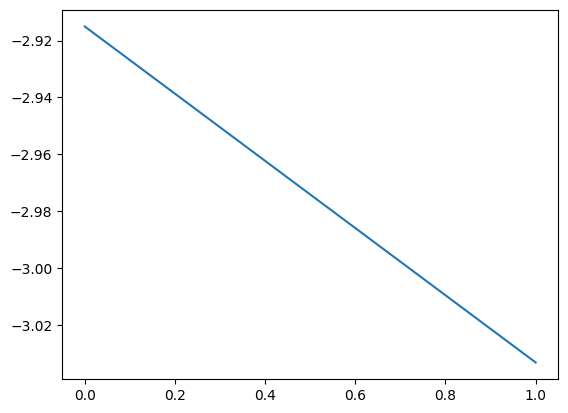

<Figure size 640x480 with 0 Axes>

In [8]:
with open(f'{MODELS_PATH}/{DATASET_NAME}/{MODEL_NAME}.hist', 'r') as hist:
    history = json.load(hist)
    
for key, values in history.items():
    plt.plot(values, label=key)
plt.show()
plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/History/{MODEL_NAME}_History.png')
plt.clf()

## Predict on Train

In [10]:
SPLIT_NAME = 'Train'

# output = denormalize(model.predict_step(train_data, start=0, steps=50, mode='sum'))
output = model.predict_step(train_data, start=25, steps=75, mode='mean')

# data_true = denormalize(train_label[0:50, :, :].numpy())
data_true = train_label[25:100, :, :].numpy()
data_predicted = output.reshape(output.shape[0], output.shape[-1])
data_true = data_true.reshape(data_true.shape[0], data_true.shape[-1])

data_true = denormalize(data_true, name='AirQuality')
data_predicted = denormalize(data_predicted, name='AirQuality')
for i in range(10):
    first_elements_arr1 = [subarr[i] for subarr in data_true]
    first_elements_arr2 = [subarr[i] for subarr in data_predicted]
    # Plotting
    plt.plot(first_elements_arr1, label='True')
    plt.plot(first_elements_arr2, label='Predicted')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title(f'Line Plot of Train Feature {i}')
    plt.legend()
    plt.show()
    plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/{SPLIT_NAME}/{MODEL_NAME}_Feature_{i}.png')
    plt.clf()

100%|██████████| 899/899 [00:09<00:00, 91.64it/s]


## Generate on Train

In [11]:
# output = denormalize(model.generate_step(train_data, start=0, steps=200, mode='mean'))
output = model.generate_step(train_data, start=25, steps=75, mode='mean')

# data_true = denormalize(train_label[0:200, :, :].numpy())
data_true = train_label[25:100, :, :].numpy()
data_predicted = output.reshape(output.shape[0], output.shape[-1])
data_true = data_true.reshape(data_true.shape[0], data_true.shape[-1])

data_true = denormalize(data_true, name='AirQuality')
data_predicted = denormalize(data_predicted, name='AirQuality')

data_predicted
for i in range(10):
    first_elements_arr1 = [subarr[i] for subarr in data_true]
    first_elements_arr2 = [subarr[i] for subarr in data_predicted]
    # Plotting
    plt.plot(first_elements_arr1, label='True')
    plt.plot(first_elements_arr2, label='Generated')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title(f'Line Plot of Train Feature {i}')
    plt.legend()
    plt.show()
    plt.savefig(f'{IMAGES_PATH}/{DATASET_NAME}/{SPLIT_NAME}/{MODEL_NAME}_Feature_{i}_GEN.png')
    plt.clf()

In [14]:

print(mmd_linear(data_true, data_predicted))  # 6.0
print(mmd_rbf(data_true, data_predicted))  # 0.5822
print(mmd_poly(data_true, data_predicted))  # 2436.5

101121.5
0.014445681124925613
52360292352.0
